# Prepare audio data for image recognition

The data is pretty good, but there's a few samples that aren't exactly 1 second long and some samples that are either truncated or don't contain very much of the word.

The code in the notebook attempts to filter out the broken audio so that we are only using good audio.

We then generate spectrograms of each word. We mix in background noise with the words to make it a more realistic audio sample.

## Download data set
Download from: https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz - approx 2.3 GB

And then run
```
tar -xzf data_speech_commands_v0.02.tar.gz -C speech_data
```

In [1]:
!conda activate ai

In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install ipywidgets --upgrade
!pip install jupyter --upgrade


  Using cached ipywidgets-7.8.5-py2.py3-none-any.whl (124 kB)
  Using cached jupyterlab_widgets-1.1.11-py3-none-any.whl (246 kB)
  Using cached widgetsnbextension-3.6.10-py2.py3-none-any.whl (1.6 MB)
  Using cached comm-0.1.4-py3-none-any.whl (6.6 kB)


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops

In [4]:
!python --version


Python 3.6.13 :: Anaconda, Inc.


In [8]:
pip install tensorflow==2.6.2
pip install tensorflow-io==0.21.0

In [5]:
SPEECH_DATA='speech_data'

In [3]:
ls

 Le volume dans le lecteur C s'appelle c
 Le num�ro de s�rie du volume est 82B6-0B0B

 R�pertoire de c:\mSFE\voice-controlled-robot\model

29/05/2025  18:43    <DIR>          .
18/03/2025  16:15    <DIR>          ..
13/03/2025  11:24    <DIR>          .ipynb_checkpoints
18/03/2025  13:10    <DIR>          .vscode
11/03/2025  19:23    <DIR>          _background_noise_
14/04/2025  10:18             4�672 Convert Trained Model To TFLite.ipynb
29/05/2025  18:44           423�047 Generate Training Data Command Recognition11.ipynb
12/03/2025  09:32    <DIR>          myenv
11/03/2025  11:21             2�354 README.md
11/03/2025  11:21               148 requirements.txt
29/05/2025  18:36    <DIR>          speech_data
26/03/2025  12:38        11�415�734 Train Model-All Words.ipynb
               5 fichier(s)       11�845�955 octets
               7 R�p(s)  26�959�028�224 octets libres


In [6]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [7]:
# list of folders we want to process in the speech_data folder
command_words = [
    'forward',
    'backward',
    'down',
    'up',
    '_invalid',
]
nonsense_words = [
    'stop',
    'go',
    'on',
    'left',
    'right',
    'off',
    'learn',
    'yes',
    'no',
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'follow',
    'tree',
    'bed',
    'bird',
    'cat',
    'dog',
    'happy',
    'house',
    'marvin',
    'sheila',
    'visual',
    'wow',
]

In [8]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [9]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [10]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [11]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [18]:
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Installing C:\Users\User\anaconda3\envs\ai\lib\site-packages\widgetsnbextension\static -> jupyter-js-widgets
Making directory: C:\ProgramData\jupyter\nbextensions\jupyter-js-widgets\
Copying: C:\Users\User\anaconda3\envs\ai\lib\site-packages\widgetsnbextension\static\extension.js -> C:\ProgramData\jupyter\nbextensions\jupyter-js-widgets\extension.js
Copying: C:\Users\User\anaconda3\envs\ai\lib\site-packages\widgetsnbextension\static\extension.js.map -> C:\ProgramData\jupyter\nbextensions\jupyter-js-widgets\extension.js.map
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    


In [12]:
from tqdm import tqdm


In [13]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, label, repeat=1):
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the command words
for word in tqdm(command_words, desc="Processing words"):
    if '_' not in word:
        repeat = 40 if word in ('forward','backward') else 20
        process_word(word, command_words.index(word), repeat=repeat)
        
# all the nonsense words
for word in tqdm(nonsense_words, desc="Processing words"):
    if '_' not in word:
        process_word(word, command_words.index('_invalid'), repeat=1)

print(len(train), len(test), len(validate))

Processing words: 100%|██████████| 31/31 [32:59<00:00, 63.85s/it]


217907 27386 27182


In [17]:
#☺!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [18]:
#!jupyter nbextension enable --py widgetsnbextension

In [19]:
#conda install -c conda-forge ipywidgets

In [20]:
#pip install --upgrade ipywidgets


In [14]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))
    
print(len(train), len(test), len(validate))

Processing Background Noise: 100%|██████████| 11/11 [00:58<00:00,  5.33s/it]

236612 29735 29516


In [15]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))

Processing problem noise: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


In [16]:
print(len(train), len(test), len(validate))

240537 30227 30006


In [17]:
# randomise the training samples
np.random.shuffle(train)

In [18]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [19]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [20]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [21]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

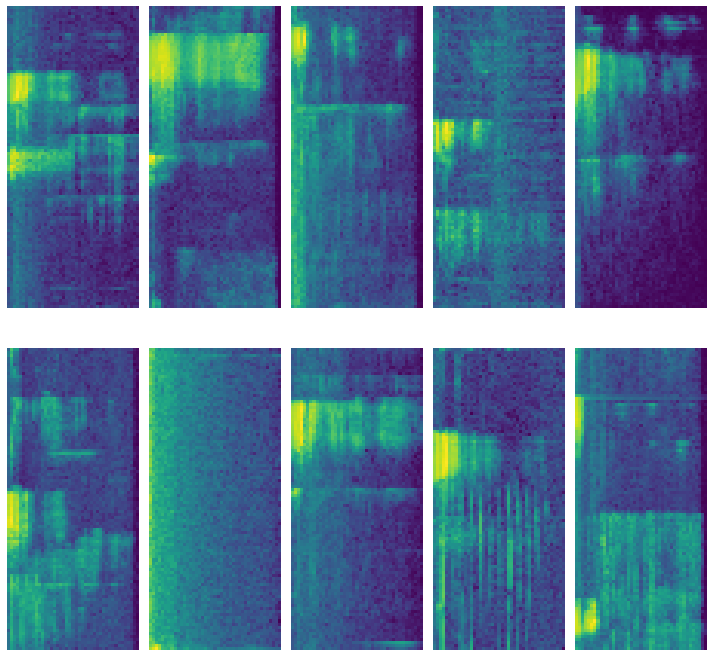

In [22]:
word_index = command_words.index("up")

X_left = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_left[:10], IMG_WIDTH, IMG_HEIGHT)

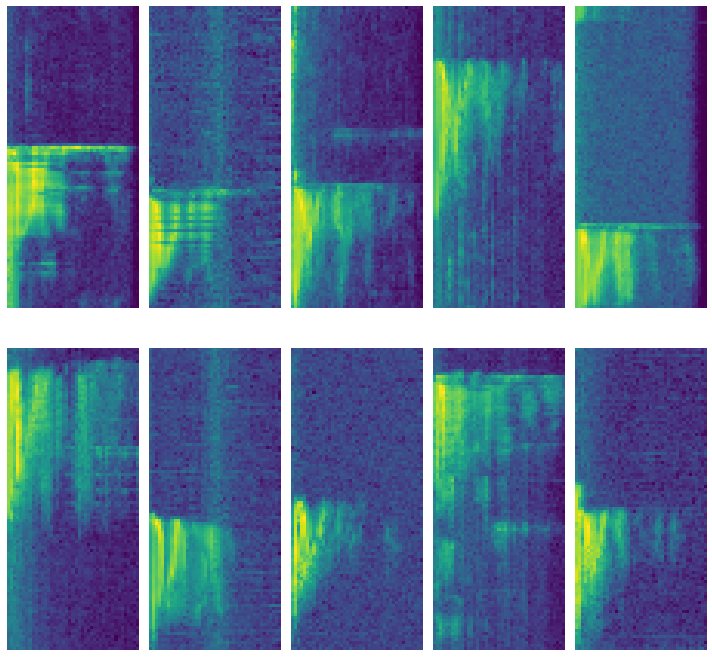

In [23]:
word_index = command_words.index("down")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)